D:\dong\papers\OPTRAM3\SR_vegetation_growth_merge\OZNET.csv
D:\dong\papers\OPTRAM3\parameter\linear_OZNET.txt
All done


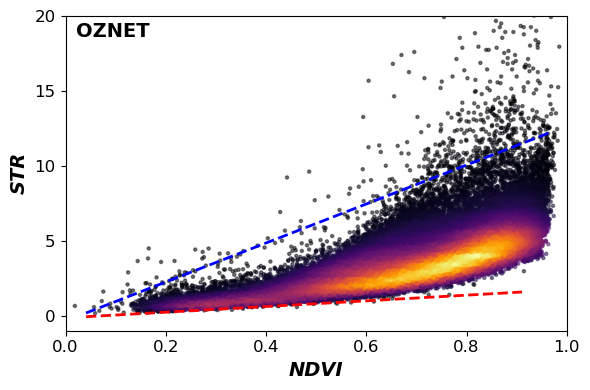

In [27]:
import os
import numpy as np
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import rasterio
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity



def load_data(file_path, vi_type='NDVI'):
    """
    Load data from CSV file and filter based on the chosen VI type.
    """
    df = pd.read_csv(file_path)
    
    # Convert 'VI' and 'STR' to numeric values (handle NDVI or SAVI dynamically)
    df[vi_type] = pd.to_numeric(df[vi_type], errors='coerce')
    df['STR'] = pd.to_numeric(df['STR'], errors='coerce')
    
    # Filter rows where the VI value is greater than 0
    df = df[df[vi_type] > 0]
    
    return df

def find_boundaries(df, vi_steps_dry, vi_steps_wet, window_size=15, k=0.1, alpha=0.1, min_threshold=0.05, vi_threshold=0.1, alpha_low_vi=0.5, vi_type='NDVI'):
    """
    Find dry and wet boundaries for a given VI type.
    """
    lower_boundary = []
    upper_boundary = []

    # Define function to remove outliers
    def remove_outliers(str_values):
        Q1 = str_values.quantile(0.25)
        Q3 = str_values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return str_values[(str_values >= lower_bound) & (str_values <= upper_bound)]

    # Define function to filter STR values for low VI values
    def filter_str_values(str_values, vi):
        if vi < vi_threshold:
            max_str_value = df['STR'].quantile(0.99)
            str_values = str_values[str_values <= max_str_value]
        return str_values

    # Calculate dry boundary
    for vi in vi_steps_dry:
        str_values = df[df[vi_type].between(vi, vi + 0.01)]['STR']
        str_values = remove_outliers(str_values)
        str_values = filter_str_values(str_values, vi)
        if not str_values.empty:
            str_values_sorted = str_values.sort_values()
            if len(str_values_sorted) >= window_size:
                std = str_values_sorted.std()
                current_alpha = alpha_low_vi if vi < vi_threshold else alpha
                threshold = max(k * std * (1 + current_alpha * vi), min_threshold)
                for i in range(len(str_values_sorted) - window_size + 1):
                    window = str_values_sorted.iloc[i:i + window_size]
                    if (window.max() - window.min() < threshold) and window.diff().dropna().gt(0).all():
                        lower_boundary.append((vi, window.iloc[0]))
                        break

    # Calculate wet boundary
    for vi in vi_steps_wet:
        str_values = df[df[vi_type].between(vi, vi + 0.01)]['STR']
        str_values = remove_outliers(str_values)
        str_values = filter_str_values(str_values, vi)
        if not str_values.empty:
            str_values_sorted = str_values.sort_values(ascending=False)
            if len(str_values_sorted) >= window_size:
                std = str_values_sorted.std()
                current_alpha = alpha_low_vi if vi < vi_threshold else alpha
                threshold = max(k * std * (1 + current_alpha * vi), min_threshold)
                for i in range(len(str_values_sorted) - window_size + 1):
                    window = str_values_sorted.iloc[i:i + window_size]
                    if window.max() - window.min() < threshold:
                        upper_boundary.append((vi, window.iloc[0]))
                        break

    # Convert results to DataFrame
    lower_boundary_df = pd.DataFrame(lower_boundary, columns=['VI', 'STR_dry'])
    upper_boundary_df = pd.DataFrame(upper_boundary, columns=['VI', 'STR_wet'])

    # Remove outliers from the wet boundary
    if not upper_boundary_df.empty:
        z_scores = (upper_boundary_df['STR_wet'] - upper_boundary_df['STR_wet'].mean()) / upper_boundary_df['STR_wet'].std()
        upper_boundary_df = upper_boundary_df[np.abs(z_scores) < 2.5]

    return lower_boundary_df, upper_boundary_df


def save_fit_statistics(fit_type, fit_dry, fit_wet, rmse_dry, rmse_wet, r2_dry, r2_wet, output_file_path):
    with open(output_file_path, 'w') as f:
        f.write(f"Fit Type: {fit_type}\n\n")
        f.write(f"Dry Edge Fit:\n  Equation: {fit_dry}\n  RMSE: {rmse_dry:.4f}\n  R²: {r2_dry:.4f}\n\n")
        f.write(f"Wet Edge Fit:\n  Equation: {fit_wet}\n  RMSE: {rmse_wet:.4f}\n  R²: {r2_wet:.4f}\n")

def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

def fit_edges(lower_boundary_df, upper_boundary_df, fit_type):
    def select_top_80_percent(df, x_col, y_col, fit_func, *params):
        y_pred = fit_func(df[x_col], *params)
        residuals = np.abs(df[y_col] - y_pred)
        threshold = np.percentile(residuals, 60)
        selected_df = df[residuals <= threshold]
        return selected_df

    if fit_type == 'linear':
        slope_dry, intercept_dry = np.polyfit(lower_boundary_df['VI'], lower_boundary_df['STR_dry'], 1)
        slope_wet, intercept_wet = np.polyfit(upper_boundary_df['VI'], upper_boundary_df['STR_wet'], 1)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', lambda x, m, b: m * x + b, slope_dry, intercept_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', lambda x, m, b: m * x + b, slope_wet, intercept_wet)
        
        slope_dry, intercept_dry = np.polyfit(lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], 1)
        slope_wet, intercept_wet = np.polyfit(upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], 1)
        return slope_dry, intercept_dry, slope_wet, intercept_wet

    elif fit_type == 'polynomial':
        coeffs_dry = np.polyfit(lower_boundary_df['VI'], lower_boundary_df['STR_dry'], 2)
        coeffs_wet = np.polyfit(upper_boundary_df['VI'], upper_boundary_df['STR_wet'], 2)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', lambda x, coeffs: np.polyval(coeffs, x), coeffs_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', lambda x, coeffs: np.polyval(coeffs, x), coeffs_wet)
        
        coeffs_dry = np.polyfit(lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], 2)
        coeffs_wet = np.polyfit(upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], 2)
        return coeffs_dry, coeffs_wet

    elif fit_type == 'exponential':
        popt_dry, _ = curve_fit(exponential_func, lower_boundary_df['VI'], lower_boundary_df['STR_dry'], maxfev=10000)
        popt_wet, _ = curve_fit(exponential_func, upper_boundary_df['VI'], upper_boundary_df['STR_wet'], maxfev=10000)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', exponential_func, *popt_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', exponential_func, *popt_wet)
        
        popt_dry, _ = curve_fit(exponential_func, lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], maxfev=10000)
        popt_wet, _ = curve_fit(exponential_func, upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], maxfev=10000)
        return popt_dry, popt_wet

def calculate_and_save_statistics(fit_type, fit_params, lower_boundary_df, upper_boundary_df, output_file_path):
    if fit_type == 'linear':
        slope_dry, intercept_dry, slope_wet, intercept_wet = fit_params
        fit_dry = f"y = {slope_dry:.2f}x + {intercept_dry:.2f}"
        fit_wet = f"y = {slope_wet:.2f}x + {intercept_wet:.2f}"
        y_pred_dry = slope_dry * lower_boundary_df['VI'] + intercept_dry
        y_pred_wet = slope_wet * upper_boundary_df['VI'] + intercept_wet
    elif fit_type == 'polynomial':
        coeffs_dry, coeffs_wet = fit_params
        fit_dry = f"y = {coeffs_dry[0]:.2f}x² + {coeffs_dry[1]:.2f}x + {coeffs_dry[2]:.2f}"
        fit_wet = f"y = {coeffs_wet[0]:.2f}x² + {coeffs_wet[1]:.2f}x + {coeffs_wet[2]:.2f}"
        y_pred_dry = np.polyval(coeffs_dry, lower_boundary_df['VI'])
        y_pred_wet = np.polyval(coeffs_wet, upper_boundary_df['VI'])
    elif fit_type == 'exponential':
        popt_dry, popt_wet = fit_params
        fit_dry = f"y = {popt_dry[0]:.2f}e^({popt_dry[1]:.2f}x) + {popt_dry[2]:.2f}"
        fit_wet = f"y = {popt_wet[0]:.2f}e^({popt_wet[1]:.2f}x) + {popt_wet[2]:.2f}"
        y_pred_dry = exponential_func(lower_boundary_df['VI'], *popt_dry)
        y_pred_wet = exponential_func(upper_boundary_df['VI'], *popt_wet)

    rmse_dry = np.sqrt(mean_squared_error(lower_boundary_df['STR_dry'], y_pred_dry))
    rmse_wet = np.sqrt(mean_squared_error(upper_boundary_df['STR_wet'], y_pred_wet))
    r2_dry = r2_score(lower_boundary_df['STR_dry'], y_pred_dry)
    r2_wet = r2_score(upper_boundary_df['STR_wet'], y_pred_wet)

    save_fit_statistics(fit_type, fit_dry, fit_wet, rmse_dry, rmse_wet, r2_dry, r2_wet, output_file_path)

def fit_and_plot_optimized(
    df, lower_boundary_df, upper_boundary_df, fit_type, title, output_file_path,
    stats_output_path, additional_points=None, vi_type='NDVI'
):
    fig, ax = plt.subplots(figsize=(6, 4))

    # 获取 x 和 y 数据
    x = df[vi_type].values
    y = df['STR'].values

    # 对数据进行采样以优化性能
    sample_size = min(len(x), 50000)  # 限制绘图点数
    sampled_indices = np.random.choice(len(x), sample_size, replace=False)
    x_sampled = x[sampled_indices]
    y_sampled = y[sampled_indices]

    # 使用 KernelDensity 计算密度
    xy = np.vstack([x_sampled, y_sampled]).T
    kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
    kde.fit(xy)
    log_density = kde.score_samples(xy)
    density = np.exp(log_density)

    # 绘制密度散点图
    scatter = ax.scatter(
        x_sampled, y_sampled, c=density, cmap='inferno', s=5, alpha=0.5, label='Point Density'
    )

    # 绘制额外的点（如果提供）
    if additional_points is not None:
        ax.scatter(
            additional_points[vi_type], additional_points['STR'],
            c='green', s=20, marker='x', label='Measured Points'
        )

    # 添加颜色条并调整位置
    # cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
    # cbar.set_label('Point Density', fontsize=12)

    # 绘制拟合线
    if fit_type == 'linear':
        slope_dry, intercept_dry, slope_wet, intercept_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], slope_dry * lower_boundary_df['VI'] + intercept_dry,
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Linear)'
        )
        ax.plot(
            upper_boundary_df['VI'], slope_wet * upper_boundary_df['VI'] + intercept_wet,
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Linear)'
        )
    elif fit_type == 'polynomial':
        coeffs_dry, coeffs_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], np.polyval(coeffs_dry, lower_boundary_df['VI']),
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Polynomial)'
        )
        ax.plot(
            upper_boundary_df['VI'], np.polyval(coeffs_wet, upper_boundary_df['VI']),
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Polynomial)'
        )
    elif fit_type == 'exponential':
        popt_dry, popt_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], exponential_func(lower_boundary_df['VI'], *popt_dry),
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Exponential)'
        )
        ax.plot(
            upper_boundary_df['VI'], exponential_func(upper_boundary_df['VI'], *popt_wet),
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Exponential)'
        )

    # 自定义图表
    # ax.legend(loc='upper right', fontsize=10, frameon=True)
    ax.set_xlabel(vi_type, fontsize=14, fontweight='bold', fontstyle='italic')
    ax.set_ylabel('STR', fontsize=14, fontweight='bold', fontstyle='italic')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 20)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.linspace(0, 20, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.text(
        0.02, 0.98, title, fontsize=14, fontweight='bold', ha='left', va='top',
        transform=ax.transAxes
    )

    # 标注拟合线含义
    # ax.text(0.7, 18, 'Dry Edge', color='red', fontsize=12, fontweight='bold')
    # ax.text(0.7, 16, 'Wet Edge', color='blue', fontsize=12, fontweight='bold')

    # 保存并显示图像
    plt.tight_layout()
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    plt.show()

input_VI = "NDVI"  # "SAVI", "NDVI"
site = "OZNET"
fit_type = 'linear'  # 'linear', 'polynomial', 'exponential' 
work_dir = rf"D:\dong\papers\OPTRAM3\SR_vegetation_growth_merge"
file_name = "OZNET.csv"  # make sure file name is correct
file_path = os.path.join(work_dir, file_name)
print(file_path)
df = load_data(file_path, input_VI)

vi_min = df[input_VI].min()
vi_max = df[input_VI].max()
vi_steps_dry = np.arange(vi_min , vi_max, 0.01)  # you can change the range and steps
vi_steps_wet = np.arange(vi_min, vi_max, 0.01)  # you can change the range and steps
lower_boundary_df, upper_boundary_df = find_boundaries(df, vi_steps_dry, vi_steps_wet, vi_type=input_VI)

# find the boundary
fit_params = fit_edges(lower_boundary_df, upper_boundary_df, fit_type)

export_floder = r'D:\dong\papers\OPTRAM3\parameter'
# save statistic data
stats_output_path = os.path.join(export_floder, f"{fit_type}_{site}.txt")
calculate_and_save_statistics(fit_type, fit_params, lower_boundary_df, upper_boundary_df, stats_output_path)
print(stats_output_path)

print("All done")

# save figure
title = f'{site}'
output_file_path = os.path.join(r"D:\dong\papers\OPTRAM3\Fig\Feature_space", f"{site}-{fit_type}.png")
fit_and_plot_optimized(df, lower_boundary_df, upper_boundary_df, fit_type, title, output_file_path, stats_output_path, vi_type=input_VI)

Processing file: D:\dong\papers\OPTRAM3\MinQin_SR_sites\SONTE-China-MinQin-01.csv
Lower boundary size: 20
Upper boundary size: 20
  Running NDVI with linear fit...


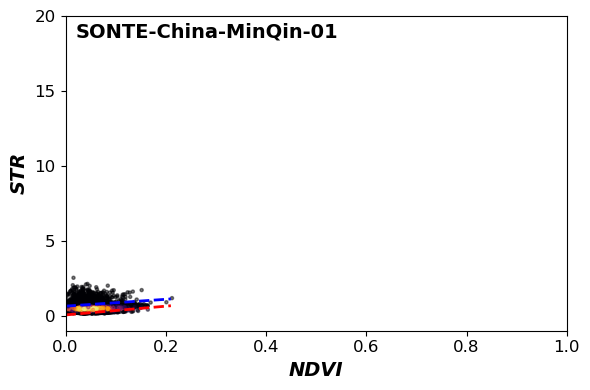

  Running NDVI with polynomial fit...


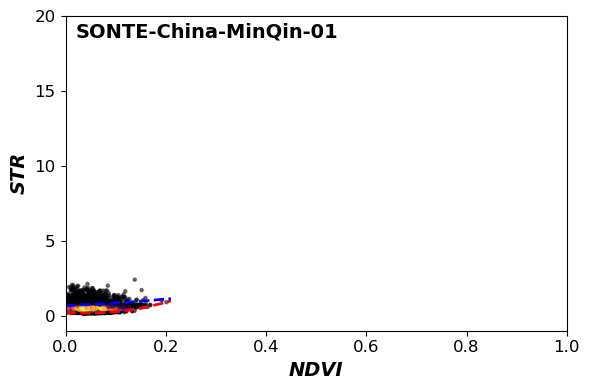

  Running NDVI with exponential fit...


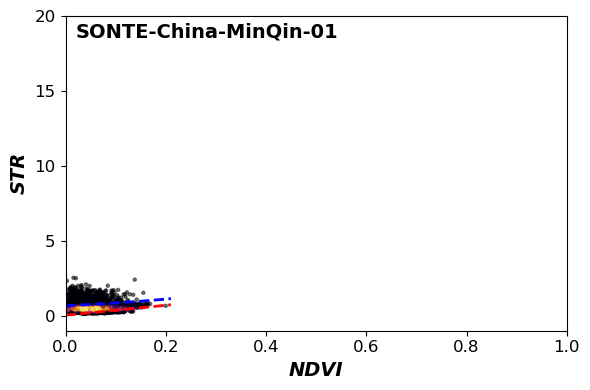

Lower boundary size: 17
Upper boundary size: 17
  Running SAVI with linear fit...


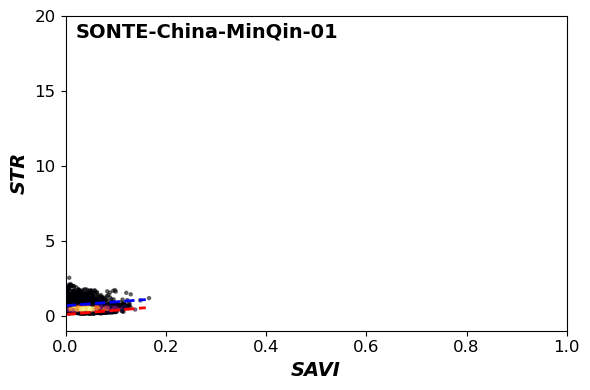

  Running SAVI with polynomial fit...


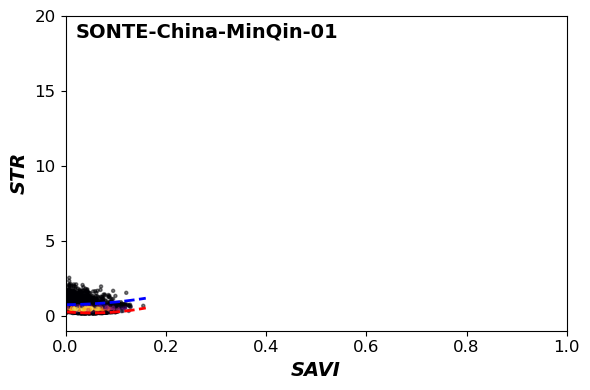

  Running SAVI with exponential fit...


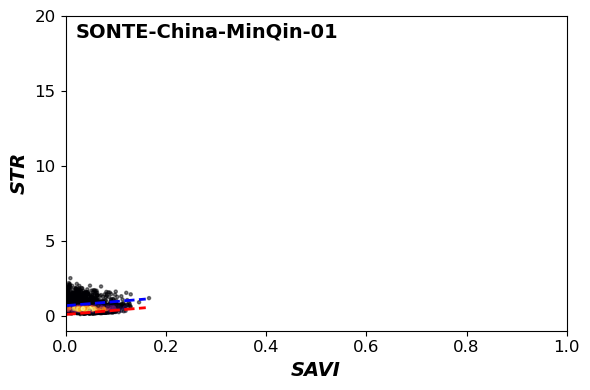

Processing file: D:\dong\papers\OPTRAM3\MinQin_SR_sites\SONTE-China-MinQin-02.csv
Lower boundary size: 20
Upper boundary size: 20
  Running NDVI with linear fit...


In [ ]:
import os
import numpy as np
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import rasterio
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity



def load_data(file_path, vi_type='NDVI'):
    """
    Load data from CSV file and filter based on the chosen VI type.
    """
    df = pd.read_csv(file_path)
    
    # Convert 'VI' and 'STR' to numeric values (handle NDVI or SAVI dynamically)
    df[vi_type] = pd.to_numeric(df[vi_type], errors='coerce')
    df['STR'] = pd.to_numeric(df['STR'], errors='coerce')
    
    # Filter rows where the VI value is greater than 0
    df = df[df[vi_type] > 0]
    
    return df

def find_boundaries(
    df, vi_steps_dry, vi_steps_wet, window_size=15, k=0.1, alpha=0.1,
    min_threshold=0.05, vi_threshold=0.1, alpha_low_vi=0.5, vi_type='NDVI'
):
    lower_boundary = []
    upper_boundary = []

    def remove_outliers(str_values):
        Q1 = str_values.quantile(0.25)
        Q3 = str_values.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return str_values[(str_values >= lower_bound) & (str_values <= upper_bound)]

    def filter_str_values(str_values, vi):
        if vi < vi_threshold:
            max_str_value = df['STR'].quantile(0.99)
            str_values = str_values[str_values <= max_str_value]
        return str_values

    # Calculate dry boundary
    for vi in vi_steps_dry:
        str_values = df[df[vi_type].between(vi, vi + 0.01)]['STR']
        str_values = remove_outliers(str_values)
        str_values = filter_str_values(str_values, vi)
        if not str_values.empty:
            lower_boundary.append((vi, str_values.min()))  # Simplified: use minimum STR value for dry edge

    # If lower_boundary is empty, use 0.1% STR as fallback
    if not lower_boundary:
        min_vi = vi_steps_dry.min()
        min_str_value = df['STR'].quantile(0.001)  # 0.1% quantile
        print(f"Fallback: Using 0.1% STR ({min_str_value}) for dry boundary.")
        lower_boundary.append((min_vi, min_str_value))

    # Calculate wet boundary
    for vi in vi_steps_wet:
        str_values = df[df[vi_type].between(vi, vi + 0.01)]['STR']
        str_values = remove_outliers(str_values)
        str_values = filter_str_values(str_values, vi)
        if not str_values.empty:
            str_values_sorted = str_values.sort_values(ascending=False)
            upper_boundary.append((vi, str_values_sorted.iloc[0]))

    # Convert results to DataFrame
    lower_boundary_df = pd.DataFrame(lower_boundary, columns=['VI', 'STR_dry'])
    upper_boundary_df = pd.DataFrame(upper_boundary, columns=['VI', 'STR_wet'])

    # Debugging outputs
    print(f"Lower boundary size: {len(lower_boundary)}")
    print(f"Upper boundary size: {len(upper_boundary)}")

    if lower_boundary_df.empty:
        print("Warning: Lower boundary is empty.")
    if upper_boundary_df.empty:
        print("Warning: Upper boundary is empty.")

    return lower_boundary_df, upper_boundary_df



def save_fit_statistics(fit_type, fit_dry, fit_wet, rmse_dry, rmse_wet, r2_dry, r2_wet, output_file_path):
    with open(output_file_path, 'w') as f:
        f.write(f"Fit Type: {fit_type}\n\n")
        f.write(f"Dry Edge Fit:\n  Equation: {fit_dry}\n  RMSE: {rmse_dry:.4f}\n  R²: {r2_dry:.4f}\n\n")
        f.write(f"Wet Edge Fit:\n  Equation: {fit_wet}\n  RMSE: {rmse_wet:.4f}\n  R²: {r2_wet:.4f}\n")

def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

def fit_edges(lower_boundary_df, upper_boundary_df, fit_type):
    if lower_boundary_df.empty or upper_boundary_df.empty:
        print("Warning: One of the boundary DataFrames is empty. Skipping fitting process.")
        return None  # Return None or some default value to handle the case gracefully

    def select_top_80_percent(df, x_col, y_col, fit_func, *params):
        y_pred = fit_func(df[x_col], *params)
        residuals = np.abs(df[y_col] - y_pred)
        threshold = np.percentile(residuals, 60)
        selected_df = df[residuals <= threshold]
        return selected_df

    if fit_type == 'linear':
        slope_dry, intercept_dry = np.polyfit(lower_boundary_df['VI'], lower_boundary_df['STR_dry'], 1)
        slope_wet, intercept_wet = np.polyfit(upper_boundary_df['VI'], upper_boundary_df['STR_wet'], 1)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', lambda x, m, b: m * x + b, slope_dry, intercept_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', lambda x, m, b: m * x + b, slope_wet, intercept_wet)
        
        slope_dry, intercept_dry = np.polyfit(lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], 1)
        slope_wet, intercept_wet = np.polyfit(upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], 1)
        return slope_dry, intercept_dry, slope_wet, intercept_wet

    elif fit_type == 'polynomial':
        coeffs_dry = np.polyfit(lower_boundary_df['VI'], lower_boundary_df['STR_dry'], 2)
        coeffs_wet = np.polyfit(upper_boundary_df['VI'], upper_boundary_df['STR_wet'], 2)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', lambda x, coeffs: np.polyval(coeffs, x), coeffs_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', lambda x, coeffs: np.polyval(coeffs, x), coeffs_wet)
        
        coeffs_dry = np.polyfit(lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], 2)
        coeffs_wet = np.polyfit(upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], 2)
        return coeffs_dry, coeffs_wet

    elif fit_type == 'exponential':
        popt_dry, _ = curve_fit(exponential_func, lower_boundary_df['VI'], lower_boundary_df['STR_dry'], maxfev=10000)
        popt_wet, _ = curve_fit(exponential_func, upper_boundary_df['VI'], upper_boundary_df['STR_wet'], maxfev=10000)
        
        lower_boundary_df_80 = select_top_80_percent(
            lower_boundary_df, 'VI', 'STR_dry', exponential_func, *popt_dry)
        upper_boundary_df_80 = select_top_80_percent(
            upper_boundary_df, 'VI', 'STR_wet', exponential_func, *popt_wet)
        
        popt_dry, _ = curve_fit(exponential_func, lower_boundary_df_80['VI'], lower_boundary_df_80['STR_dry'], maxfev=10000)
        popt_wet, _ = curve_fit(exponential_func, upper_boundary_df_80['VI'], upper_boundary_df_80['STR_wet'], maxfev=10000)
        return popt_dry, popt_wet

def calculate_and_save_statistics(fit_type, fit_params, lower_boundary_df, upper_boundary_df, output_file_path):
    if fit_type == 'linear':
        slope_dry, intercept_dry, slope_wet, intercept_wet = fit_params
        fit_dry = f"y = {slope_dry:.2f}x + {intercept_dry:.2f}"
        fit_wet = f"y = {slope_wet:.2f}x + {intercept_wet:.2f}"
        y_pred_dry = slope_dry * lower_boundary_df['VI'] + intercept_dry
        y_pred_wet = slope_wet * upper_boundary_df['VI'] + intercept_wet
    elif fit_type == 'polynomial':
        coeffs_dry, coeffs_wet = fit_params
        fit_dry = f"y = {coeffs_dry[0]:.2f}x² + {coeffs_dry[1]:.2f}x + {coeffs_dry[2]:.2f}"
        fit_wet = f"y = {coeffs_wet[0]:.2f}x² + {coeffs_wet[1]:.2f}x + {coeffs_wet[2]:.2f}"
        y_pred_dry = np.polyval(coeffs_dry, lower_boundary_df['VI'])
        y_pred_wet = np.polyval(coeffs_wet, upper_boundary_df['VI'])
    elif fit_type == 'exponential':
        popt_dry, popt_wet = fit_params
        fit_dry = f"y = {popt_dry[0]:.2f}e^({popt_dry[1]:.2f}x) + {popt_dry[2]:.2f}"
        fit_wet = f"y = {popt_wet[0]:.2f}e^({popt_wet[1]:.2f}x) + {popt_wet[2]:.2f}"
        y_pred_dry = exponential_func(lower_boundary_df['VI'], *popt_dry)
        y_pred_wet = exponential_func(upper_boundary_df['VI'], *popt_wet)

    rmse_dry = np.sqrt(mean_squared_error(lower_boundary_df['STR_dry'], y_pred_dry))
    rmse_wet = np.sqrt(mean_squared_error(upper_boundary_df['STR_wet'], y_pred_wet))
    r2_dry = r2_score(lower_boundary_df['STR_dry'], y_pred_dry)
    r2_wet = r2_score(upper_boundary_df['STR_wet'], y_pred_wet)

    save_fit_statistics(fit_type, fit_dry, fit_wet, rmse_dry, rmse_wet, r2_dry, r2_wet, output_file_path)

def fit_and_plot_optimized(
    df, lower_boundary_df, upper_boundary_df, fit_type, title, output_file_path,
    stats_output_path, additional_points=None, vi_type='NDVI'
):
    fig, ax = plt.subplots(figsize=(6, 4))

    # 获取 x 和 y 数据
    x = df[vi_type].values
    y = df['STR'].values

    # 对数据进行采样以优化性能
    sample_size = min(len(x), 50000)  # 限制绘图点数
    sampled_indices = np.random.choice(len(x), sample_size, replace=False)
    x_sampled = x[sampled_indices]
    y_sampled = y[sampled_indices]

    # 使用 KernelDensity 计算密度
    xy = np.vstack([x_sampled, y_sampled]).T
    kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
    kde.fit(xy)
    log_density = kde.score_samples(xy)
    density = np.exp(log_density)

    # 绘制密度散点图
    scatter = ax.scatter(
        x_sampled, y_sampled, c=density, cmap='inferno', s=5, alpha=0.5, label='Point Density'
    )

    # 绘制额外的点（如果提供）
    if additional_points is not None:
        ax.scatter(
            additional_points[vi_type], additional_points['STR'],
            c='green', s=20, marker='x', label='Measured Points'
        )

    # 绘制拟合线
    if fit_type == 'linear':
        slope_dry, intercept_dry, slope_wet, intercept_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], slope_dry * lower_boundary_df['VI'] + intercept_dry,
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Linear)'
        )
        ax.plot(
            upper_boundary_df['VI'], slope_wet * upper_boundary_df['VI'] + intercept_wet,
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Linear)'
        )
    elif fit_type == 'polynomial':
        coeffs_dry, coeffs_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], np.polyval(coeffs_dry, lower_boundary_df['VI']),
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Polynomial)'
        )
        ax.plot(
            upper_boundary_df['VI'], np.polyval(coeffs_wet, upper_boundary_df['VI']),
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Polynomial)'
        )
    elif fit_type == 'exponential':
        popt_dry, popt_wet = fit_params
        ax.plot(
            lower_boundary_df['VI'], exponential_func(lower_boundary_df['VI'], *popt_dry),
            color='red', linestyle='--', linewidth=2, label='Dry Edge (Exponential)'
        )
        ax.plot(
            upper_boundary_df['VI'], exponential_func(upper_boundary_df['VI'], *popt_wet),
            color='blue', linestyle='--', linewidth=2, label='Wet Edge (Exponential)'
        )

    # 自定义图表
    # ax.legend(loc='upper right', fontsize=10, frameon=True)
    ax.set_xlabel(vi_type, fontsize=14, fontweight='bold', fontstyle='italic')
    ax.set_ylabel('STR', fontsize=14, fontweight='bold', fontstyle='italic')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, 20)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.linspace(0, 20, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.text(
        0.02, 0.98, title, fontsize=14, fontweight='bold', ha='left', va='top',
        transform=ax.transAxes
    )
     # 保存并显示图像
    plt.tight_layout()
    plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
    plt.show()

# 定义文件夹路径和其他参数
work_dir = r"D:\dong\papers\OPTRAM3\MinQin_SR_sites"
export_folder = r"D:\dong\papers\OPTRAM3\parameter\parametersforsinglesite"
output_figure_folder = r"D:\dong\papers\OPTRAM3\Fig\Single_site"

vi_types = ["NDVI", "SAVI"]  # 需要处理的VI类型
fit_types = ['linear', 'polynomial', 'exponential']  # 需要进行的拟合类型

# 遍历文件夹中的所有 CSV 文件
for file_name in os.listdir(work_dir):
    if file_name.endswith(".csv"):  # 只处理CSV文件
        file_path = os.path.join(work_dir, file_name)
        base_name = os.path.splitext(file_name)[0]  # 移除扩展名
        print(f"Processing file: {file_path}")
        
        # 遍历每种VI类型
        for vi_type in vi_types:
            # 加载数据
            df = load_data(file_path, vi_type)

            vi_min = df[vi_type].min()
            vi_max = df[vi_type].max()
            vi_steps_dry = np.arange(vi_min, vi_max, 0.01)  # 你可以调整步长
            vi_steps_wet = np.arange(vi_min, vi_max, 0.01)

            # 找到边界
            lower_boundary_df, upper_boundary_df = find_boundaries(
                df, vi_steps_dry, vi_steps_wet, vi_type=vi_type
            )

            # 遍历每种拟合类型
            for fit_type in fit_types:
                print(f"  Running {vi_type} with {fit_type} fit...")

                # 拟合边界
                fit_params = fit_edges(lower_boundary_df, upper_boundary_df, fit_type)

                # 保存统计数据
                stats_output_path = os.path.join(
                    export_folder, f"{fit_type}_{base_name}_{vi_type}.txt"
                )
                calculate_and_save_statistics(
                    fit_type, fit_params, lower_boundary_df, upper_boundary_df, stats_output_path
                )

                # 保存图像
                title = f"{base_name}"
                output_file_path = os.path.join(
                    output_figure_folder, f"{base_name}-{vi_type}-{fit_type}.png"
                )
                fit_and_plot_optimized(
                    df, lower_boundary_df, upper_boundary_df, fit_type, title,
                    output_file_path, stats_output_path, vi_type=vi_type
                )

print("All files processed successfully!")
